In [32]:
%load_ext autoreload
%autoreload 1

import os
import sys

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

from src.data_analysis.data_analysis import fetch_historical_data
from src.modeling.statistical_methods import (
    machine_learning_cycle,
    feature_importance_mdi,
    feature_importance_mda,
    feature_importance_sfi,
    feature_importance_orthogonal,
    weighted_kendalls_tau
)
from src.modeling import PurgedKFold

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# # Feature Importance Analysis
# 
# This notebook executes the machine learning pipeline and analyzes feature importance using four distinct methods:
# 1. **MDI (Mean Decrease Impurity):** Standard Random Forest importance (on Orthogonal Features).
# 2. **MDA (Mean Decrease Accuracy):** Permutation importance (on Orthogonal Features).
# 3. **SFI (Single Feature Importance):** Predictive power of features in isolation (on Original Features).
# 4. **Orthogonal Importance:** Importance of PCA components vs. their explained variance.
# 
# Finally, we verify the results using Weighted Kendall's Tau.

In [37]:
# --- Configuration ---
config = {
    "dollar_threshold": 1e9,
    "horizon": 5,
    "pt": 1,
    "sl": 1,
    "min_ret": 0.0005,
    "n_splits": 3,
    "pct_embargo": 0.01,
    "feature_whitelist": None
}

# --- Data Loading ---
data_path = os.path.join(project_root, "data/binance/python/data/spot/daily/klines/BTCUSDT/1h/BTCUSDT_consolidated_klines.csv")

raw_tick_data = fetch_historical_data(
    symbol="BTC/USDT",
    timeframe="1h",
    start_date="2020-01-01T00:00:00Z",
    end_date="2025-08-01T00:00:00Z",
    data_path=data_path,
)
raw_tick_data.index = pd.to_datetime(raw_tick_data.index)

print(f"Data loaded: {raw_tick_data.shape}")

Data loaded: (48905, 12)


In [38]:
# --- Pipeline Execution ---
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("Running ML Pipeline... (This may take a few minutes)")
trained_model, scores, X, y, sample_weights, t1, features, pca = machine_learning_cycle(raw_tick_data, model, config)

print(f"\nCross-validation F1 Scores: {scores}")
print(f"Average F1 Score: {np.mean(scores):.4f}")

Running ML Pipeline... (This may take a few minutes)

>>> Function 'step_1_data_structuring' executed in 1.5579 seconds

>>> Function 'frac_diff_ffd' executed in 4.8950 seconds

>>> Function 'frac_diff_ffd' executed in 0.6140 seconds

>>> Function 'frac_diff_ffd' executed in 1.3216 seconds

>>> Function 'frac_diff_ffd' executed in 2.5123 seconds

>>> Function 'frac_diff_ffd' executed in 3.4432 seconds

>>> Function 'find_minimum_d' executed in 15.4621 seconds

>>> Function 'step_2_feature_engineering' executed in 15.5829 seconds

>>> Function 'step_3_labeling_and_weighting' executed in 5.0902 seconds

--- Filtering Features by Whitelist ---
Original Feature Count: 75
Keeping 6 features: ['avg_volume_20', 'ADX_14', 'Stoch_D_pct', 'open_pct_lag_1', 'VPT', 'low_pct_lag_1']

>>> Function 'filter_features_whitelist' executed in 0.0005 seconds

>>> Function 'orthogonalize_pca' executed in 0.0035 seconds

>>> Function 'machine_learning_cycle' executed in 22.9609 seconds

Cross-validation F1 S

In [29]:
# ## 1. Mean Decrease Impurity (MDI)
# MDI measures how much each feature decreases impurity (Gini) in the trees. Here, applied to the **Orthogonal Features (Principal Components)**.


>>> Function 'feature_importance_mdi' executed in 0.1907 seconds


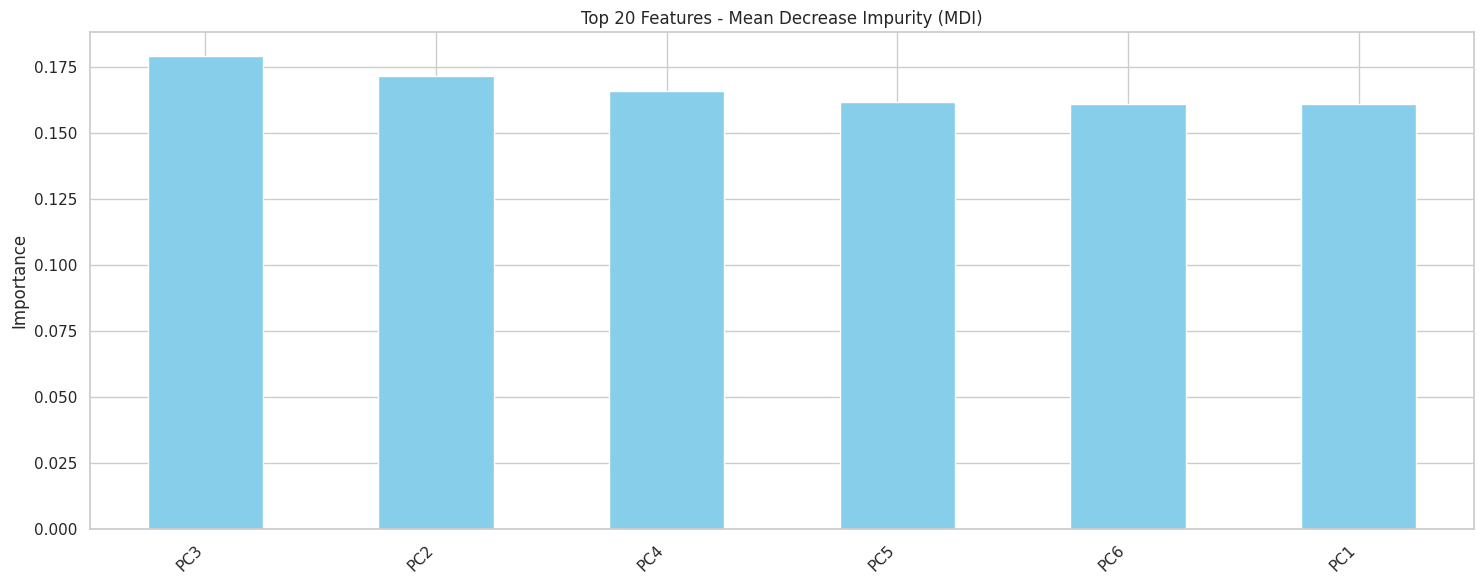

In [40]:
mdi_importance = feature_importance_mdi(trained_model, X, y)

plt.figure(figsize=(15, 6))
mdi_importance.head(20).plot(kind='bar', color='skyblue')
plt.title("Top 20 Features - Mean Decrease Impurity (MDI)")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [41]:
mdi_importance

PC3    0.179084
PC2    0.171584
PC4    0.165951
PC5    0.161635
PC6    0.160938
PC1    0.160809
Name: MDI, dtype: float64

In [42]:
# ## 2. Mean Decrease Accuracy (MDA)
# MDA measures how much the model's performance drops when a feature is randomly shuffled. Applied to **Orthogonal Features**.


>>> Function 'feature_importance_mda' executed in 1.1874 seconds


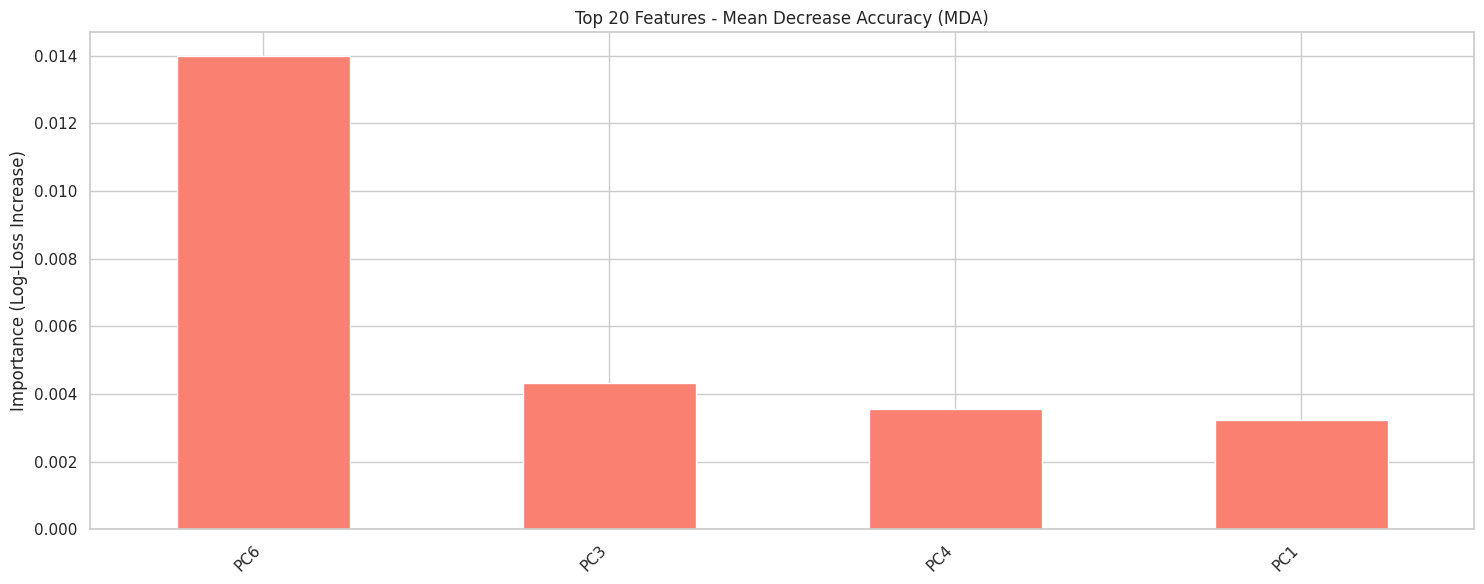

In [43]:
cv = PurgedKFold(
    n_splits=config["n_splits"],
    t1=t1,
    pct_embargo=config["pct_embargo"],
)

mda_importance = feature_importance_mda(trained_model, X, y, cv, sample_weights, t1)

# Invert importance scores because default scoring is 'neg_log_loss' (Loss_orig - Loss_perm).
# We want (Loss_perm - Loss_orig), where positive values indicate the feature is important.
mda_importance = -mda_importance

# Remove 'full_model' and filter out features with negative importance (harmful features)
plot_mda = mda_importance.drop('full_model', errors='ignore')
plot_mda = plot_mda[plot_mda > 0]
plot_mda.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(15, 6))
plot_mda.head(20).plot(kind='bar', color='salmon')
plt.title("Top 20 Features - Mean Decrease Accuracy (MDA)")
plt.ylabel("Importance (Log-Loss Increase)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [44]:
mda_original = feature_importance_mda(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    features.loc[X.index],
    y,
    cv,
    sample_weights,
    t1,
)
print(mda_original[mda_original > 0])



>>> Function 'feature_importance_mda' executed in 7.1888 seconds
full_model         0.750010
Volume             0.001326
BB_Width_pct       0.001325
low_pct_lag_1      0.001065
low_pct_lag_3      0.000908
close_pct_lag_2    0.000655
DMP_14             0.000332
STC_10_23_50       0.000313
open_pct_lag_4     0.000166
avg_volume_20      0.000142
returns_z_score    0.000108
pct_change         0.000033
KAMA               0.000033
dtype: float64


In [23]:
# ## 3. Single Feature Importance (SFI)
# SFI trains a separate model for each feature. This is applied to the **Original Features**, making it highly interpretable for identifying the best raw technical indicators.


>>> Function 'feature_importance_sfi' executed in 41.3212 seconds


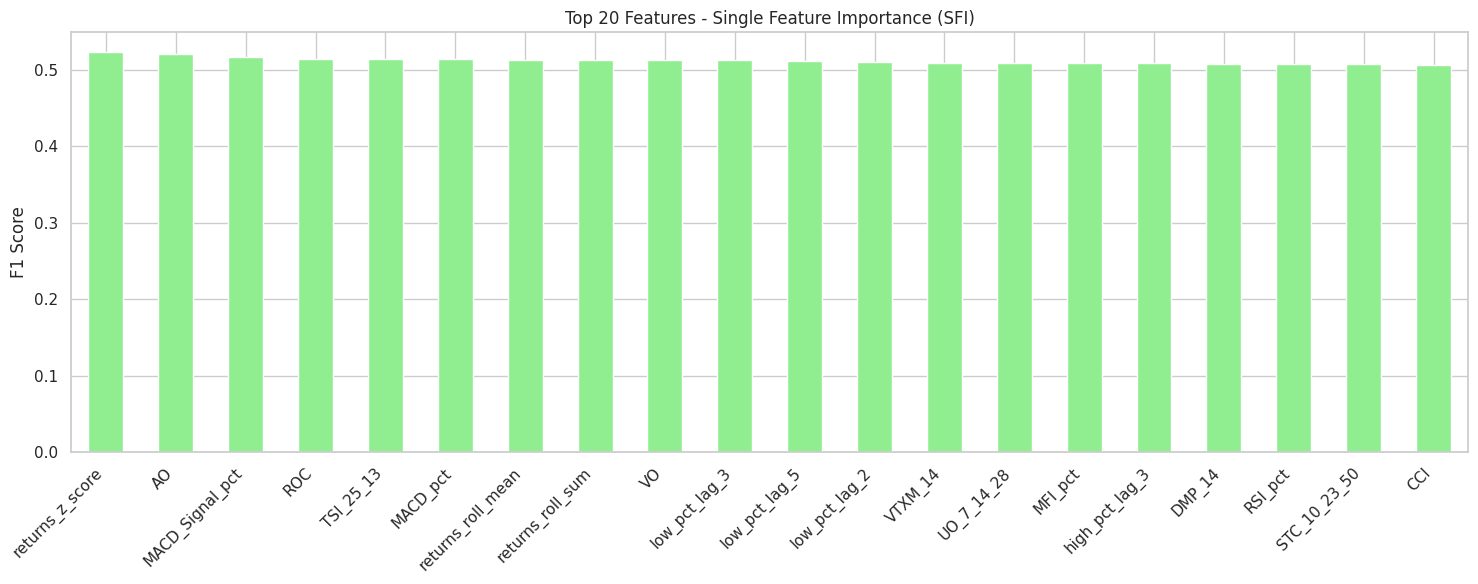

In [46]:
# We align original features with the processed target index
features_aligned = features.loc[X.index]

sfi_importance = feature_importance_sfi(
    trained_model,
    features_aligned,
    y,
    cv,
    sample_weights,
    t1,
)

plt.figure(figsize=(15, 6))
sfi_importance.head(20).plot(kind='bar', color='lightgreen')
plt.title("Top 20 Features - Single Feature Importance (SFI)")
plt.ylabel("F1 Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [25]:
# ## 4. Orthogonal Feature Importance & Kendall's Tau
# Comparing the ML importance of Principal Components against their Explained Variance.


>>> Function 'feature_importance_orthogonal' executed in 0.1984 seconds
Weighted Kendall's Tau Correlation: 0.2721


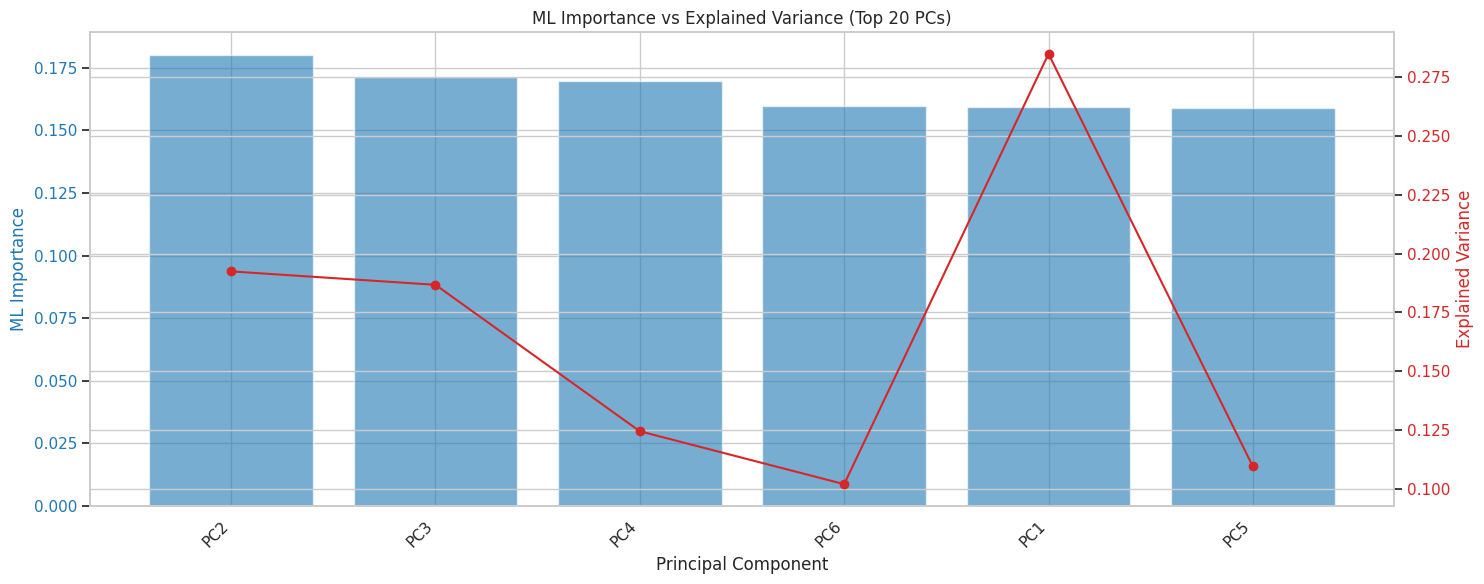

PC2    0.180212
PC3    0.171458
PC4    0.169845
PC6    0.159876
PC1    0.159551
PC5    0.159057
Name: Orthogonal Importance, dtype: float64


In [47]:
ortho_importance = feature_importance_orthogonal(
    trained_model,
    X,
    y,
    sample_weights,
    pca,
)

# Calculate Correlation
ml_importance = ortho_importance["Orthogonal Importance"]
eigen_importance = ortho_importance["Explained Variance"]
tau, p_value = weighted_kendalls_tau(ml_importance, eigen_importance)

print(f"Weighted Kendall's Tau Correlation: {tau:.4f}")
if not np.isnan(p_value):
    print(f"p-value: {p_value:.4f}")

# Plot
fig, ax1 = plt.subplots(figsize=(15, 6))

color = 'tab:blue'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('ML Importance', color=color)
ax1.bar(ortho_importance.index[:20], ortho_importance["Orthogonal Importance"][:20], color=color, alpha=0.6, label='ML Importance')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Explained Variance', color=color)
ax2.plot(ortho_importance.index[:20], ortho_importance["Explained Variance"][:20], color=color, marker='o', label='Explained Variance')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("ML Importance vs Explained Variance (Top 20 PCs)")
fig.tight_layout()
plt.show()

print(ml_importance[ml_importance>0])

In [27]:
# ## 5. Autocorrelation Analysis of Top Features
# We analyze the serial correlation of the top relevant features identified by SFI (Original Features).


--- Top 5 SFI Features for ACF/PACF Analysis ---
['open_pct_lag_5', 'pct_change', 'run', 'MFI_pct', 'high_pct_lag_5']


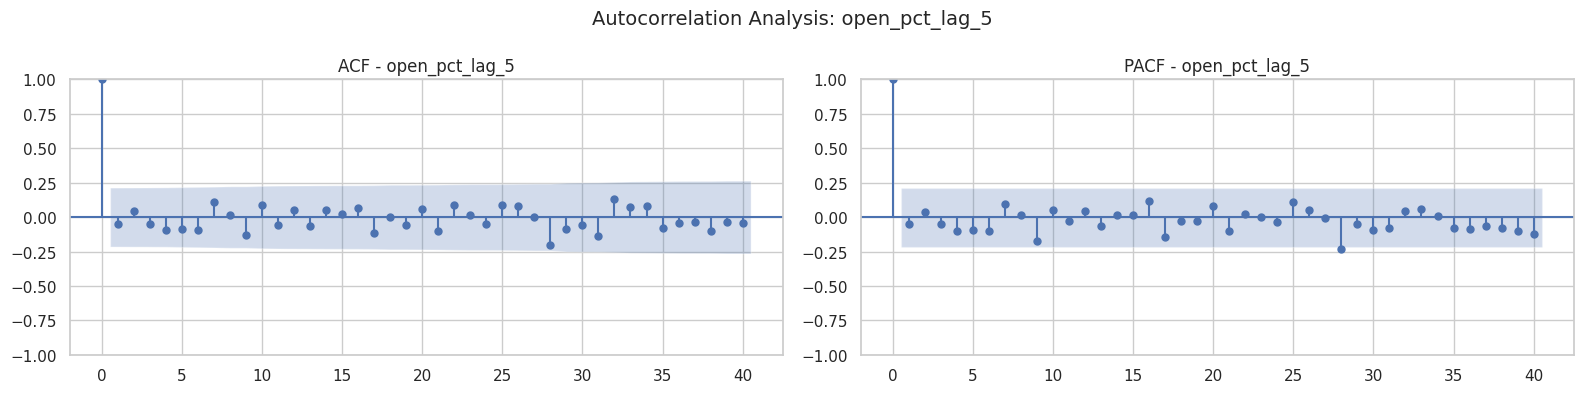

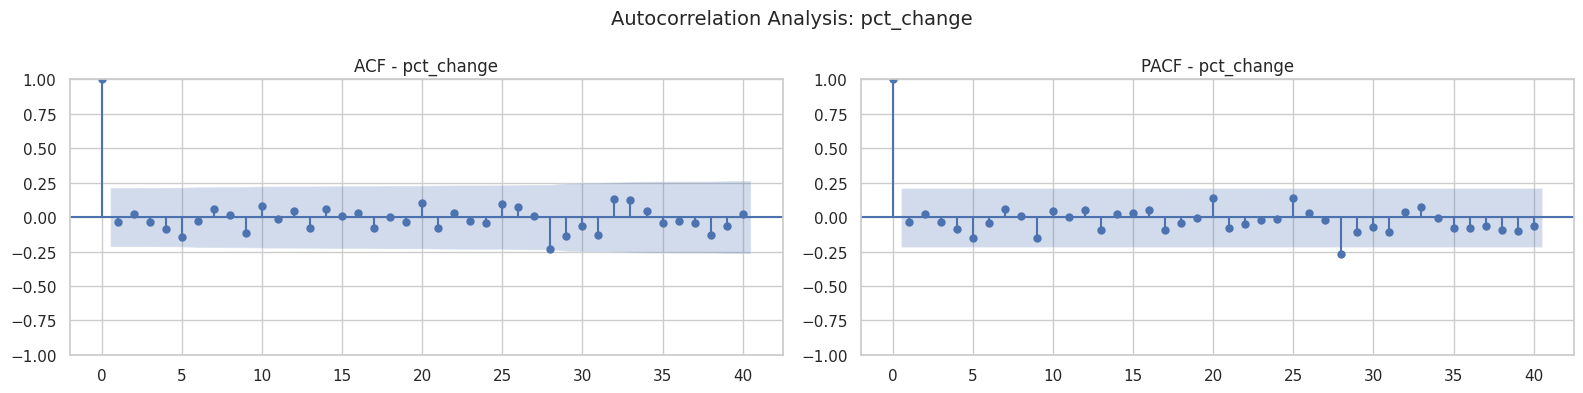

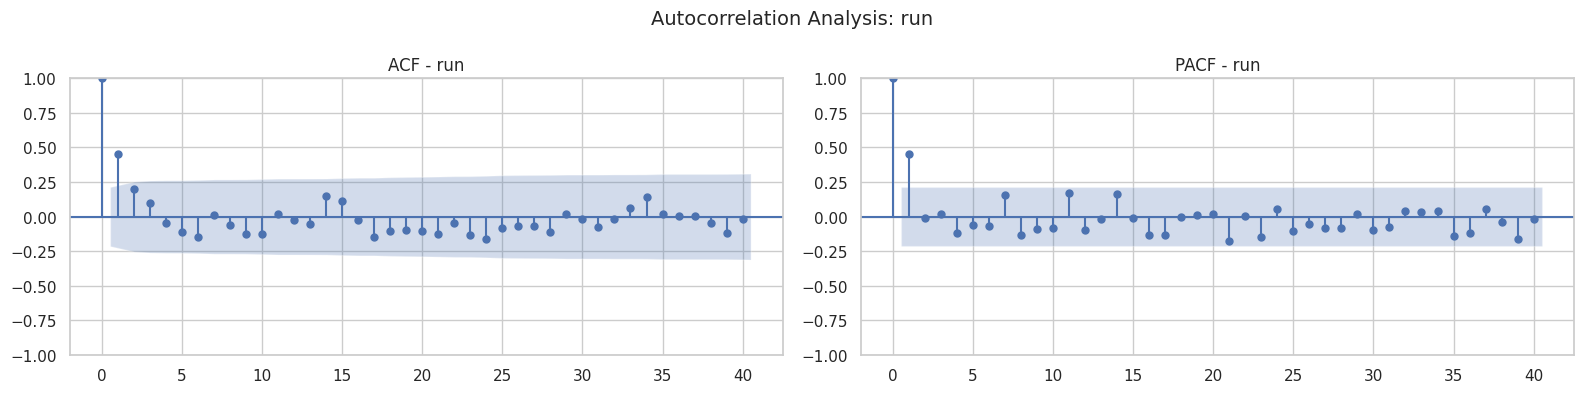

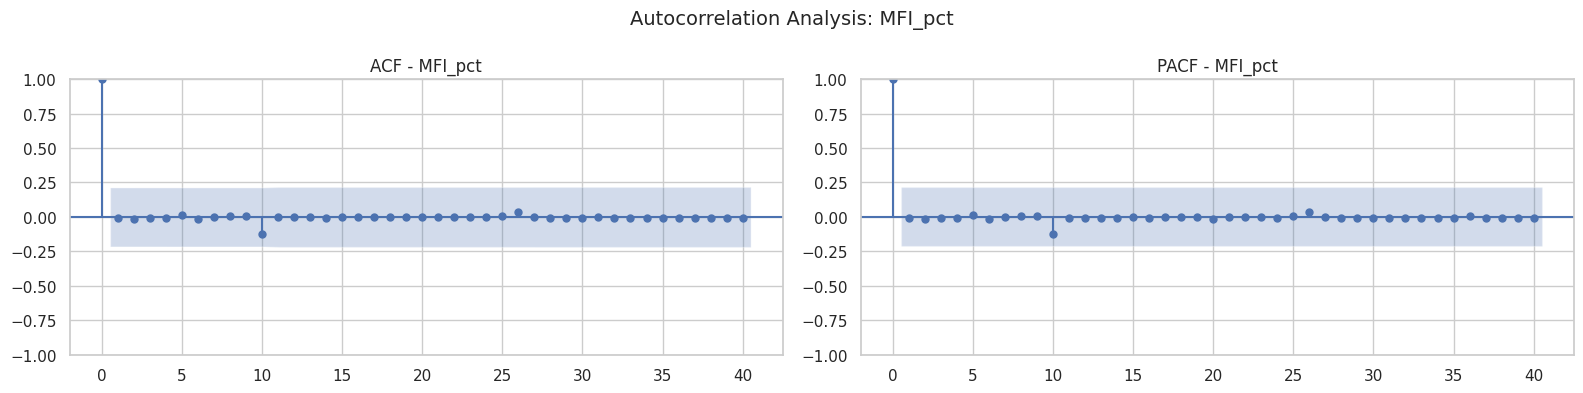

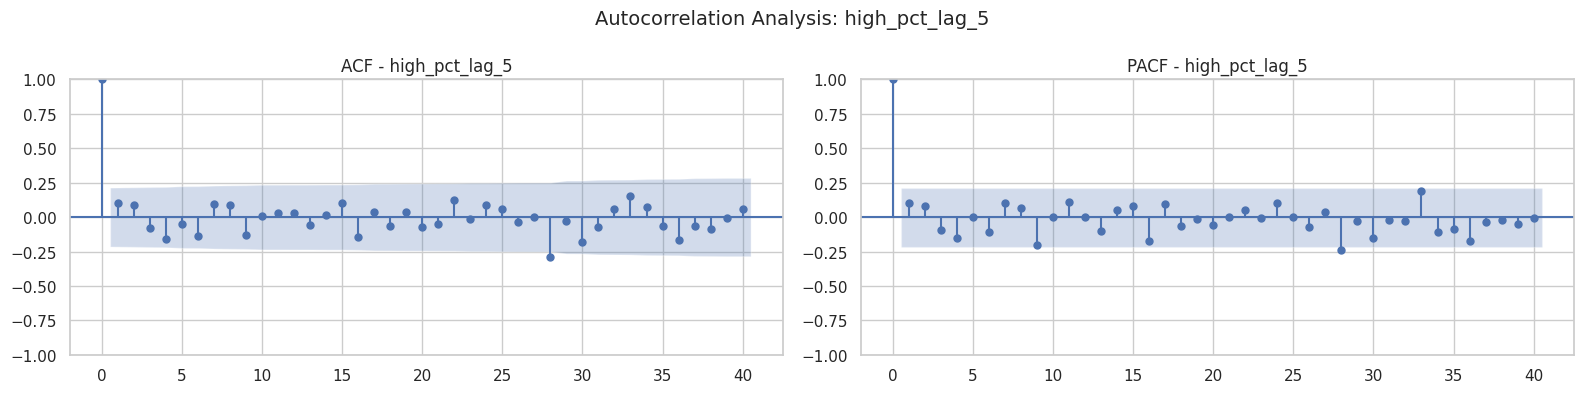

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

top_n_features = 5
top_features = sfi_importance.head(top_n_features).index

print(f"\n--- Top {top_n_features} SFI Features for ACF/PACF Analysis ---")
print(top_features.tolist())

for feature_name in top_features:
    feature_data = features_aligned[feature_name].dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    fig.suptitle(f'Autocorrelation Analysis: {feature_name}', fontsize=14)
    
    plot_acf(feature_data, lags=40, ax=axes[0], title=f'ACF - {feature_name}')
    plot_pacf(feature_data, lags=40, ax=axes[1], title=f'PACF - {feature_name}')
    
    plt.tight_layout()
    plt.show()